<a href="https://colab.research.google.com/github/o-fugi/FURSPColexification/blob/main/code/Prediction_with_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ColabFiles/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ColabFiles


In [3]:
import pandas as pd
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from functools import reduce
import torch

In [2]:
# install a newer version of matplotlib
%%capture
!pip install matplotlib --upgrade

import matplotlib.pyplot as plt
import matplotlib as mpl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# install sentence-trasnformers
%%capture
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model = SentenceTransformer('whaleloops/phrase-bert')

In [8]:
# import semantic shift dataset

sem_shift_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/cleaned_dat_sem_shift.csv')
sem_shift_df['meaning1'] = sem_shift_df['meaning1_clean']
sem_shift_df['meaning2'] = sem_shift_df['meaning2_clean']

sem_shift_df.at[697, 'meaning1'] = 'furuncul'
sem_shift_df.at[1521, 'meaning2'] = 'geometrid'

# try a little more filtering -- or don't! 
# shift_class_df = sem_shift_df[sem_shift_df['realizations'] > 1].reset_index()
shift_class_df = sem_shift_df

In [147]:
# @title run this cell if you want to load english data

# shift_class_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/cleaned_classified_df.csv', encoding='ISO-8859-1')

# # remove NaN rows
# shift_class_df['Bleached sense'] = shift_class_df['Bleached sense'].fillna('NaN')
# shift_class_df = shift_class_df[shift_class_df['Bleached sense']!='NaN']

# # remove completely duplicated rows
# shift_class_df = shift_class_df[~shift_class_df.duplicated()]

# # these seem a little outside of our area of study 
# shift_class_df = shift_class_df[shift_class_df['Type of change']!= 'grammaticalization']
# shift_class_df = shift_class_df[shift_class_df['Type of change']!= 'synaesthesia']
# shift_class_df = shift_class_df[shift_class_df['Type of change']!= 'bleaching']

# # allowed_types = ['metaphor', 'narrowing', 'pejoration', 'broadening', 'metonymy', 'amelioration', 'antonymy', 'analogy', 'broadening, metaphor', 'pejoration, homophony']
# # shift_class_df = shift_class_df[shift_class_df['Type of change'].isin(allowed_types)]

# shift_class_df = shift_class_df.reset_index()

# # get rid of punctuation in the senses for the English data

# def cleanString(s):
#   s = s.lower()
#   s = s.replace("'", "")
#   s = s.replace(",", "")
#   s = s.replace(";", "")
#   s = s.lower()
#   return s

# shift_class_df['meaning1'] = shift_class_df['meaning1'].apply(cleanString)
# shift_class_df['meaning2'] = shift_class_df['meaning2'].apply(cleanString)

## PCA

In [9]:
# create a dictionary for the embeddings
vec_dic = {} # This will be a dictionary that easily allows us to access the embedding for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings or concreteness values

encoding_len = len(model.encode('yikes'))

for i in range(len(shift_class_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = shift_class_df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  try:   
    if x not in vec_dic:
      xvec = np.array(model.encode(x))
      vec_dic[x] = xvec
  except:
    error_senses.add(x)

  try:  
    if y not in vec_dic:
      yvec = np.array(model.encode(y))
      vec_dic[y] = yvec
  except: 
    error_senses.add(y)

error_senses = list(error_senses) # List of all senses that could not be converted to embeddings. Should be empty right now with phrase BERT
senses = list(vec_dic.keys()) # List of all concepts

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses.

In [10]:
# create dataframe with a pair of embeddings for each shift

all_vars_df = pd.DataFrame()
all_vars_df['meaning1'] = shift_class_df['meaning1']
all_vars_df['meaning2'] = shift_class_df['meaning2']

# #if working with DatSemShift, might be helpful
all_vars_df['realizations'] = shift_class_df['realizations']

# #if working with the English database, these are helpful
# all_vars_df['word'] = shift_class_df['Word']
# all_vars_df['type'] = shift_class_df['Type of change']
# all_vars_df['date'] = shift_class_df['date']
# all_vars_df['pos'] = shift_class_df['POS']


vec_df = pd.DataFrame.from_dict(vec_dic, orient='index').reset_index().rename(columns={'index':'Word'})
# vec_df_normalized = vec_df[range(encoding_len)].div(np.linalg.norm(vec_df[range(encoding_len)], axis=1), axis=0) # idea from Gemma's paper 
# vec_df_normalized['Word'] = vec_df['Word']
vec_meaning_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [all_vars_df, vec_df])
vec_meaning_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [vec_meaning_df, vec_df])
vec_meaning_df = vec_meaning_df.drop(['Word_x', 'Word_y'], axis=1)

In [11]:
# create dataframe with one difference embedding for each shift

vec_diff_df = pd.DataFrame()

for i in range(encoding_len):
  vec_diff_df[i] = vec_meaning_df[str(i) + "_y"] - vec_meaning_df[str(i) + "_x"]
  # vec_diff_df[i + encoding_len] = vec_diff_df[i]**2 # idea from Gemma's paper

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [12]:
# create dataframe with all shifts and difference vectors 

source_shift_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [all_vars_df, vec_diff_df])

In [13]:
# perform pca, just so the gaussian mixture will perform a little better
# x = source_shift_df.drop(['word', 'meaning1', 'meaning2', 'type', 'pos', 'date'], axis=1).values # if working with English database
x = source_shift_df.drop(['meaning1', 'meaning2', 'realizations'], axis=1).values
scaler = StandardScaler()
scaler.fit(x)
x_scale = scaler.transform(x)

n_dimensions = 50

# do PCA
pca = PCA(n_components=n_dimensions)
pca.fit(x_scale)
components = pca.transform(x_scale)
components_df = pd.DataFrame(data = components)#.rename(columns={0:'PC_1' , 1:'PC_2', 2:"PC_3", 3:'PC_4'})

# merge back into word data
df = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True), [all_vars_df, components_df])

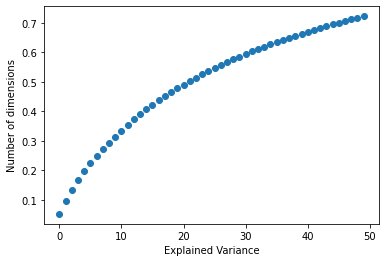

In [14]:
# check explained variance

plt.xlabel("Explained Variance")
plt.ylabel("Number of dimensions")
plt.scatter(range(n_dimensions), np.cumsum(pca.explained_variance_ratio_))

## testing models

In [76]:
# define prediction models! 

# return the target that's most similar to the source
def get_most_similar(source, potential_targets, train_df, similarity='euclidean'):
  dists = []

  for target in potential_targets:
    diff_vec = vec_dic[target] - vec_dic[source]
    dists.append(np.linalg.norm(diff_vec))

  best_target = np.argmin(dists)
  rank = list(np.argsort(dists)).index(0) + 1

  return rank, best_target

# return the shift that's the most similar to any other shift (this is the "analogy" model)
def get_dist_closest(source, potential_targets, train_df, similarity='euclidean'):
  min_dists = []

  for target in potential_targets:
    diff_vec = vec_dic[target] - vec_dic[source]
    diff_vec_pca = pca.transform(scaler.transform([diff_vec])) # pca transform
    diff_df = pd.DataFrame([diff_vec_pca[0]])
    diff_df = pd.DataFrame(np.repeat(diff_df.values, len(train_df), axis=0), columns=diff_df.columns)

    if similarity=='cosine':
      dists = np.inner(train_df[list(range(n_dimensions))], diff_vec_pca).T / (np.linalg.norm(train_df[list(range(n_dimensions))], axis=1) * np.linalg.norm(diff_df, axis=1))
    else:
      dists = np.linalg.norm(train_df[list(range(n_dimensions))] - diff_df, axis=1)
    # print(source, "->", target, "is similar to", train_df.iloc[np.argmin(dists)][['meaning1', 'meaning2']].values, "with dist", np.min(dists))
    
    min_dists.append(np.min(np.abs(dists)))
  
  best_target = np.argmin(min_dists)
  # print("Best shift is", source, "->", potential_targets[best_target])
  rank = list(np.argsort(min_dists)).index(0) + 1
  
  return rank, best_target


In [ ]:
#@title  Old models for testing 
# # return the shift that's closest to all other shifts in the train dataset, on average
# def get_dist_avg(source, potential_targets, train_df, similarity='euclidean'):
#   average_dists = []

#   for target in potential_targets:
#     diff_vec = vec_dic[target] - vec_dic[source]
#     diff_vec_pca = pca.transform(scaler.transform([diff_vec])) # pca transform
#     diff_df = pd.DataFrame([diff_vec_pca[0]])
#     diff_df = pd.DataFrame(np.repeat(diff_df.values, len(train_df), axis=0), columns=diff_df.columns)

#     if similarity=='cosine':
#       dists = np.inner(train_df[list(range(n_dimensions))], diff_vec_pca).T / (np.linalg.norm(train_df[list(range(n_dimensions))], axis=1) * np.linalg.norm(diff_df, axis=1))
#     else:
#       dists = np.linalg.norm(train_df[list(range(n_dimensions))] - diff_df, axis=1)

#     average_dists.append(np.average(dists))
  
#   best_target = np.argmin(average_dists)
#   # print(source, "->", potential_targets[0])
#   # print(potential_targets[0], average_dists[0], potential_targets[1], average_dists[1], potential_targets[2], average_dists[2], potential_targets[3], average_dists[3], potential_targets[4], average_dists[4])
#   # print(source, "->", potential_targets[best_target])
#   rank = list(np.argsort(average_dists)).index(0) + 1

#   return rank


# # return the shift that's closest to all other shifts in its GMM cluster, on average
# def get_gmm_avg(source, potential_targets, similarity='euclidean'):
#   average_dists = []

#   for target in potential_targets:
#     diff_vec = vec_dic[target] - vec_dic[source]
#     diff_vec_pca = pca.transform(scaler.transform([diff_vec])) # pca transform

#     # closest cluster, by GMM automatic labelling 
#     cluster = estimator.predict(diff_vec_pca)[0]

#     # filter train dataset to only include that cluster 
#     train_df_source = train_df[train_df['label']==cluster].reset_index()

#     diff_df = pd.DataFrame([diff_vec_pca[0]])
#     diff_df = pd.DataFrame(np.repeat(diff_df.values, len(train_df_source), axis=0), columns=diff_df.columns)

#     if similarity=='cosine':
#       dists = np.inner(train_df_source[list(range(n_dimensions))], diff_vec_pca).T / (np.linalg.norm(train_df_source[list(range(n_dimensions))], axis=1) * np.linalg.norm(diff_df, axis=1))
#     else:
#       dists = np.linalg.norm(train_df_source[list(range(n_dimensions))] - diff_df, axis=1)

#     average_dists.append(np.average(dists))
  
#   best_target = np.argmin(average_dists)
#   rank = list(np.argsort(average_dists)).index(0) + 1

#   return rank

# # return the shift that's closest to the center of its GMM cluster
# def get_gmm_center(source, potential_targets, similarity='euclidean'):
#   dists = []

#   for target in potential_targets:
#     diff_vec = vec_dic[target] - vec_dic[source]
#     diff_vec_pca = pca.transform(scaler.transform([diff_vec])) # pca transform

#     # closest cluster, by GMM automatic labelling 
#     cluster = estimator.predict(diff_vec_pca)[0]

#     if similarity=='cosine':
#       dist = np.inner(estimator.means_[cluster], diff_vec_pca).T / (np.linalg.norm(estimator.means_[cluster]) * np.linalg.norm(diff_vec_pca))
#     else:
#       dist = np.linalg.norm(estimator.means_[cluster] - diff_vec_pca)

#     dists.append(dist)
  
#   best_target = np.argmin(dists)

#   #debug
#   # if best_target==0:
#   #   target = potential_targets[0]
#   #   diff_vec = vec_dic[target] - vec_dic[source]
#   #   diff_vec_pca = pca.transform(scaler.transform([diff_vec])) # pca transform
#   #   cluster = estimator.predict(diff_vec_pca)[0]
#   #   print(source, "->", potential_targets[0], "belongs to cluster", cluster, gmm_labels[0][cluster], "->", gmm_labels[1][cluster])

#   rank = list(np.argsort(dists)).index(0) + 1

#   return rank

# # same as above, but is the sum across all clusters, weighted by the probability that the shift is in that cluster
# def get_gmm_weighted(source, potential_targets):
#   dists = []

#   for target in potential_targets:
#     diff_vec = vec_dic[target] - vec_dic[source]
#     diff_vec_pca = pca.transform(scaler.transform([diff_vec])) # pca transform

#     dist = 0

#     for center, prob in zip(estimator.means_, estimator.predict_proba(diff_vec_pca)[0]):
#       dist += np.linalg.norm(center - diff_vec_pca) * prob

#     dists.append(dist)
  
#   best_target = np.argmin(dists)

#   rank = list(np.argsort(dists)).index(0) + 1

#   return rank

# # returns the shift with the highest probability of being in any cluster 
# def get_gmm_prob(source, potential_targets):
#   probs = []

#   for target in potential_targets:
#     diff_vec = vec_dic[target] - vec_dic[source]
#     diff_vec_pca = pca.transform(scaler.transform([diff_vec])) # pca transform

#     prob = max(estimator.predict_proba(diff_vec_pca)[0])

#     probs.append(prob)
  
#   best_target = np.argmax(probs)

#   rank = list(np.argsort(probs)[::-1]).index(0) + 1

#   return rank

In [16]:
# define the method of getting a list of targets whose similarity to the source is about the same as the actual target
# e.g., if dist("food", "meat") = 2, then this returns a list of targets whose distance from "food" is about 2

def get_potential_targets(source, target, test_df, similarity_adjusted=True):
  potential_targets = []
  potential_targets.append(target) # the ACTUAL target
  # df_targets = df[df['meaning1']!=source][['meaning2']] # only take elements of the dataframe that don't have source as meaning1 
  df_targets = test_df[test_df['meaning1']!=source][['meaning2']] # we're gonna try just taking targets from the test_df to see if it improves accuracy 
  df_targets = df_targets.drop_duplicates()
  df_targets = df_targets[df_targets['meaning2']!=target]

  if similarity_adjusted: 
    df_targets = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [df_targets, vec_df])
    dists = np.linalg.norm(df_targets[range(encoding_len)] - vec_dic[source], axis=1) # get list of similarities between source and ALL targets
    dists = abs(dists - np.linalg.norm(vec_dic[target] - vec_dic[source])) # ge

    indices = np.argsort(dists)[0:4]

    potential_targets += list(df_targets.iloc[indices]['meaning2']) # take the 4 targets whose similarity to the source is closest to the actual similarity
  else: 
    potential_targets += list(df_targets['meaning2'].sample(n=4)) # take 4 random targets

  return potential_targets

In [17]:
def test_model(model_function, similarity_adjusted=True, random_state=0, run_once=False, df=df): 
  # keep track of results
  # accuracy_list = []
  # mrr_list = []
  results_df = pd.DataFrame()

  # shuffle shifts dataframe
  df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

  # run k-fold cross-validation
  k=5
  for i in range(k):
    if run_once: 
      if i != 0:
        continue
    
    # select train and test datasets
    test_df = df.loc[(int(len(df)/k)*i):(int(len(df)/k)*(i+1))]
    train_df = df.drop(test_df.index)
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    # set up columns for keeping track of results 
    test_df['accurate'] = pd.Series(dtype='boolean')
    test_df['target'] = pd.Series(dtype='string')

    num_correct = 0
    mrr_total = 0

    # run through dataset
    for i in range(len(test_df)):
      row = test_df.iloc[i]
      source = row['meaning1']
      target = row['meaning2']
    
      # make list of potential targets to choose from
      potential_targets = get_potential_targets(source, target, test_df, similarity_adjusted=similarity_adjusted)

      # calculate outcome
      result = model_function(source, potential_targets, train_df) # returns the rank of the actual target and the index of the selected target
      # if result[0] == 1:
      #   num_correct+=1 
      # mrr_total += 1/result[0]

      test_df['accurate'][i] = (result[0]==1) # true or false, did this predict accurately? 
      test_df['target'][i] = (potential_targets[result[1]]) # what shift did it predict?

    # accuracy_list.append(num_correct)
    # mrr_list.append(mrr_total)

    results_df = pd.concat([results_df, test_df[['meaning1', 'meaning2', 'realizations', 'accurate', 'target']]])

  # accuracy = np.mean(accuracy_list)/len(test_df)

  return results_df

In [ ]:
#@title Code for testing models (now in function form)
# # shuffle df for cross-validation

# #keep track of which shifts are working
# accuracy_df = pd.DataFrame()

# # n_components = 17

# df = df.sample(frac=1, random_state=0).reset_index(drop=True)
# k = 5

# # keep track of accuracies
# dist_avg = []
# dist_closest = []
# gmm_avg = []
# gmm_center = []
# most_similar = []
# gmm_weighted = []
# gmm_prob = []
# gmm_center_target = []

# dist_avg_mrr = []
# dist_closest_mrr = []
# gmm_avg_mrr = []
# gmm_center_mrr = []
# most_similar_mrr = []
# gmm_weighted_mrr = []
# gmm_prob_mrr = []
# gmm_center_target_mrr = []

# for i in range(k):
#   # if i != 0:
#   #  continue
#   # set up train and test dfs
#   test_df = df.loc[(int(len(df)/k)*i):(int(len(df)/k)*(i+1))]
#   train_df = df.drop(test_df.index)

#   train_df = train_df.reset_index(drop=True)
#   test_df = test_df.reset_index(drop=True)

#   test_df['accurate'] = pd.Series(dtype='boolean')
#   test_df['target'] = pd.Series(dtype='string')

#   # train and label GMM data
#   # estimator = GaussianMixture(n_components=n_components, covariance_type='spherical', init_params='kmeans', max_iter=30, random_state=1) # other covariance is "spherical", "diag", "tied"
#   # estimator.fit(train_df[range(n_dimensions)])

#   # label_df = pd.DataFrame(estimator.predict(np.asarray(train_df[range(n_dimensions)])))
#   # label_df = label_df.rename(columns={0:'label'})
#   # train_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='left'), [train_df, label_df])

#   # only run this if you've run the debugging cell #2 above. for clustering targets instead of shifts
#   # do another GMM on the targets only. this is to see if the GMM above is just learning common targets
#   # train_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [train_df, vec_pca_df])
#   # target_estimator = GaussianMixture(n_components=n_components, covariance_type='spherical', init_params='kmeans', max_iter=30, random_state=1) # other covariance is "spherical", "diag", "tied"
#   # target_column_names = [str(i) + '_target' for i in range(n_dimensions)]
#   # target_estimator.fit(train_df[target_column_names].values)

#   # only run this if you've run the "debugging" cell above -- for labelling each of the clusters
#   # gmm_labels = get_labels(estimator)

#   num_correct_most_similar = 0
#   num_correct_dist_avg = 0
#   num_correct_dist_closest = 0
#   num_correct_gmm_avg = 0
#   num_correct_gmm_center = 0
#   num_correct_gmm_weighted = 0
#   num_correct_gmm_prob = 0
#   num_correct_gmm_center_target = 0

#   total_most_similar_mrr = 0
#   total_dist_avg_mrr = 0
#   total_dist_closest_mrr = 0
#   total_gmm_avg_mrr = 0
#   total_gmm_center_mrr = 0
#   total_gmm_weighted_mrr = 0
#   total_gmm_prob_mrr = 0
#   total_gmm_center_target_mrr = 0

#   # use cosine similarity / euclidean distance

#   for i in range(len(test_df)):
#     row = test_df.iloc[i]
#     source = row['meaning1']
#     target = row['meaning2']
    
#     # make list of potential targets to choose from
#     potential_targets = get_potential_targets(source, target)
#     # print(source, potential_targets)

#     average_dists = []

#     most_similar_result = get_most_similar(source, potential_targets)
#     if most_similar_result==1:
#       num_correct_most_similar+=1
#     total_most_similar_mrr += 1/most_similar_result

#     # dist_avg_result = get_dist_avg(source, potential_targets)
#     # if dist_avg_result==1:
#     #   num_correct_dist_avg +=1
#     # total_dist_avg_mrr += 1/dist_avg_result

#     dist_closest_result = get_dist_closest(source, potential_targets)
#     if dist_closest_result[0]==1:
#       num_correct_dist_closest +=1
#     total_dist_closest_mrr += 1/dist_closest_result[0]

#     test_df['accurate'][i] = (dist_closest_result[0]==1)
#     test_df['target'][i] = (potential_targets[dist_closest_result[1]])
    
#     # gmm_avg_result = get_gmm_avg(source, potential_targets)
#     # if gmm_avg_result==1:
#     #   num_correct_gmm_avg += 1
#     # total_gmm_avg_mrr += 1/gmm_avg_result

#     # gmm_center_result = get_gmm_center(source, potential_targets)
#     # if gmm_center_result==1:
#     #   num_correct_gmm_center +=1
#     # total_gmm_center_mrr+= 1/gmm_center_result

#     # # just keeping this to prove that it doesn't work later -- don't uncomment
#     # # gmm_center_target_result = get_gmm_center_target(source, potential_targets)
#     # # if gmm_center_target_result==1:
#     # #   num_correct_gmm_center_target +=1
#     # # total_gmm_center_target_mrr+= 1/gmm_center_target_result

#     # gmm_weighted_result = get_gmm_weighted(source, potential_targets)
#     # if gmm_weighted_result==1:
#     #   num_correct_gmm_weighted+=1
#     # total_gmm_weighted_mrr += 1/gmm_weighted_result

#     # gmm_prob_result = get_gmm_prob(source, potential_targets)
#     # if gmm_prob_result==1:
#     #   num_correct_gmm_prob+=1
#     # total_gmm_prob_mrr += 1/gmm_prob_result

#   most_similar.append(num_correct_most_similar)
#   dist_avg.append(num_correct_dist_avg)
#   dist_closest.append(num_correct_dist_closest)
#   gmm_avg.append(num_correct_gmm_avg)
#   gmm_center.append(num_correct_gmm_center)
#   gmm_weighted.append(num_correct_gmm_weighted)
#   gmm_prob.append(num_correct_gmm_prob)
#   gmm_center_target.append(num_correct_gmm_center_target)

#   most_similar_mrr.append(total_most_similar_mrr)
#   dist_avg_mrr.append(total_dist_avg_mrr)
#   dist_closest_mrr.append(total_dist_closest_mrr)
#   gmm_avg_mrr.append(total_gmm_avg_mrr)
#   gmm_center_mrr.append(total_gmm_center_mrr)
#   gmm_weighted_mrr.append(total_gmm_weighted_mrr)
#   gmm_prob_mrr.append(total_gmm_prob_mrr)
#   gmm_center_target_mrr.append(total_gmm_center_target_mrr)

#   accuracy_df = pd.concat([accuracy_df, test_df[['meaning1', 'meaning2', 'realizations', 'accurate', 'target']]])
#   # accuracy_df = pd.concat([accuracy_df, test_df[['meaning1', 'meaning2', 'type', 'accurate', 'target', 'word', 'date', 'pos']]])

In [ ]:
#@title manually evaluate GMM model

# n = 15
# print(gmm_labels[0][n])
# print(gmm_labels[1][n])
# train_df[train_df['label']==n][['meaning1', 'meaning2']].head(30)

In [ ]:
similarity_acc = []
analogy_acc = []

# run similarity model with and without similarity adjustment
results_df = test_model(get_most_similar, run_once=False, similarity_adjusted=False)
similarity_acc.append(results_df.accurate.value_counts()[True] / len(results_df))
results_df = test_model(get_most_similar, run_once=False, similarity_adjusted=True)
similarity_acc.append(results_df.accurate.value_counts()[True] / len(results_df))

# run parallelogram model with and without similarity adjustment
results_df = test_model(get_dist_closest, run_once=False, similarity_adjusted=False)
analogy_acc.append(results_df.accurate.value_counts()[True] / len(results_df))
results_df = test_model(get_dist_closest, run_once=False, similarity_adjusted=True)
analogy_acc.append(results_df.accurate.value_counts()[True] / len(results_df))

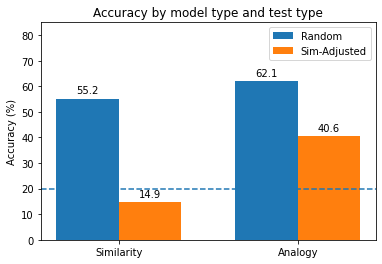

In [71]:
#@title FIG 1.A -- Accuracy by model type and test type

labels = ['Similarity', 'Analogy']
sim_labels = [round(100*i, 1) for i in similarity_acc]
ana_labels = [round(100*i, 1) for i in analogy_acc]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [sim_labels[0], ana_labels[0]], width, label='Random')
rects2 = ax.bar(x + width/2, [sim_labels[1], ana_labels[1]], width, label='Sim-Adjusted')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by model type and test type')
ax.set_xticks(x, labels=labels)
ax.legend()
ax.set_ylim(0, 85)

# fig.tight_layout()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.axhline(20, linestyle='--')

plt.show()

In [118]:
similarity_acc = []
analogy_acc = []

## NO filter on realizations

# run similarity model with and without similarity adjustment
results_df = test_model(get_most_similar, run_once=False, similarity_adjusted=False)
similarity_acc.append(results_df.accurate.value_counts()[True] / len(results_df))
results_df = test_model(get_most_similar, run_once=False, similarity_adjusted=True)
similarity_acc.append(results_df.accurate.value_counts()[True] / len(results_df))

# run parallelogram model with and without similarity adjustment
results_df = test_model(get_dist_closest, run_once=False, similarity_adjusted=False)
analogy_acc.append(results_df.accurate.value_counts()[True] / len(results_df))
results_df = test_model(get_dist_closest, run_once=False, similarity_adjusted=True)
analogy_acc.append(results_df.accurate.value_counts()[True] / len(results_df))

## realizations filtered to be > 1

# run similarity model with and without similarity adjustment
results_df = test_model(get_most_similar, run_once=False, similarity_adjusted=False, df=df[df['realizations']>1])
similarity_acc.append(results_df.accurate.value_counts()[True] / len(results_df))
results_df = test_model(get_most_similar, run_once=False, similarity_adjusted=True, df=df[df['realizations']>1])
similarity_acc.append(results_df.accurate.value_counts()[True] / len(results_df))

# run parallelogram model with and without similarity adjustment
results_df = test_model(get_dist_closest, run_once=False, similarity_adjusted=False, df=df[df['realizations']>1])
analogy_acc.append(results_df.accurate.value_counts()[True] / len(results_df))
results_df = test_model(get_dist_closest, run_once=False, similarity_adjusted=True, df=df[df['realizations']>1])
analogy_acc.append(results_df.accurate.value_counts()[True] / len(results_df))

## realizations filtered to be > 5

# run similarity model with and without similarity adjustment
results_df = test_model(get_most_similar, run_once=False, similarity_adjusted=False, df=df[df['realizations']>5])
similarity_acc.append(results_df.accurate.value_counts()[True] / len(results_df))
results_df = test_model(get_most_similar, run_once=False, similarity_adjusted=True, df=df[df['realizations']>5])
similarity_acc.append(results_df.accurate.value_counts()[True] / len(results_df))

# run parallelogram model with and without similarity adjustment
results_df = test_model(get_dist_closest, run_once=False, similarity_adjusted=False, df=df[df['realizations']>5])
analogy_acc.append(results_df.accurate.value_counts()[True] / len(results_df))
results_df = test_model(get_dist_closest, run_once=False, similarity_adjusted=True, df=df[df['realizations']>5])
analogy_acc.append(results_df.accurate.value_counts()[True] / len(results_df))

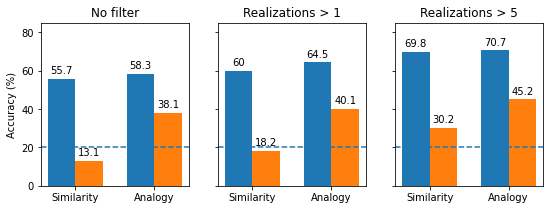

In [119]:
#@title FIG 1.B -- Accuracy by REALIZATIONS

labels = ['Similarity', 'Analogy']
sim_labels = [round(100*i, 1) for i in similarity_acc]
ana_labels = [round(100*i, 1) for i in analogy_acc]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

## general ax stuff
axs[0].set_ylim(0, 85)
axs[0].set_ylabel('Accuracy (%)')
# fig.suptitle('Accuracy for different realization filters')

## no filter on realizations

rects1 = axs[0].bar(x - width/2, [sim_labels[0], ana_labels[0]], width, label='Random')
rects2 = axs[0].bar(x + width/2, [sim_labels[1], ana_labels[1]], width, label='Sim-Adjusted')

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_xticks(x, labels=labels)
axs[0].bar_label(rects1, padding=3)
axs[0].bar_label(rects2, padding=3)
axs[0].axhline(20, linestyle='--')
axs[0].set_title("No filter")

##  realizations > 1

rects1 = axs[1].bar(x - width/2, [sim_labels[2], ana_labels[2]], width, label='Random')
rects2 = axs[1].bar(x + width/2, [sim_labels[3], ana_labels[3]], width, label='Sim-Adjusted')

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_xticks(x, labels=labels)
axs[1].bar_label(rects1, padding=3)
axs[1].bar_label(rects2, padding=3)
axs[1].axhline(20, linestyle='--')
axs[1].set_title("Realizations > 1")


##  realizations > 5

rects1 = axs[2].bar(x - width/2, [sim_labels[4], ana_labels[4]], width, label='Random')
rects2 = axs[2].bar(x + width/2, [sim_labels[5], ana_labels[5]], width, label='Sim-Adjusted')

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[2].set_xticks(x, labels=labels)
axs[2].bar_label(rects1, padding=3)
axs[2].bar_label(rects2, padding=3)
axs[2].axhline(20, linestyle='--')
axs[2].set_title("Realizations > 5")

plt.show()

In [77]:
# data cleaning DatSemShift with languages

# get the dataset all figured out 
datSemShift = pd.read_csv('/content/drive/MyDrive/ColabFiles/datsemshift.csv')

# filter semantic shifts
datSemShift = datSemShift[(datSemShift['gendirection'] == '→')]
datSemShift = datSemShift[(datSemShift['type'] == ' Semantic evolution') | (datSemShift['type'] == ' Polysemy')]
datSemShift = datSemShift[(datSemShift['language1'] == datSemShift['language2'])]
datSemShift = datSemShift[(datSemShift['lexeme1'] == datSemShift['lexeme2'])]
datSemShift = datSemShift[~datSemShift['meaning1'].str.contains('<')]
datSemShift = datSemShift[~datSemShift['meaning2'].str.contains('<')]
datSemShift = datSemShift[(datSemShift['status']!='Suspended') & (datSemShift['status']!='Rejected')]
datSemShift = datSemShift[['meaning1', 'meaning2', 'language1']]
datSemShift = datSemShift.reset_index(drop=True)

dumb_british_spellings = {"vapour":"vapor", "honour":"honor", "organisation":"organization", "harbour":"harbor", "odour":"odor", "centre":"center", "analyse":"analyze", "theatre":"theater", "colour":"color", "rumour":"rumor", "behaviour":"behavior", "armour":"armor", "grey":"gray", 
"mould":"mold", "neighbour":"neighbor", "axe":"ax", "moustache":"mustache", "plough":"plow", "mandarine":"mandarin"}
words_to_replace = {"adj":"", "gipsy":"", "albumen":"", "campanula":"", "boletus edulis":"penny bun fungus", "ursus":"", "swearword":"swear word", 'adj.':"", "coleus":"", 'n.':"", 'ОК':"ok", "typha":"cattail", "pacifica":"peaceful", "mustella":"", "smail":"", "one’s":"", "spurflower":"perennial plant", "sabre":"","equus":"", "etc.":"", "ciconia":"",  "aër":"", "panthera":"panther", "еrinaceus":"", "e.g.":"", "centaurea":"thistle", "moschiferus":"", "apterus":"", "pyrrhocoris":"", "smn.":"", "pritchardia":"", "100":"one hundred", "sabrefish":"sabre carp", "putorius":"", "adv.":"", "petromyzontidae":"", "botaurus":"", "standart":"standard", "leccinum":"", "sg.":"", "gemini":"Gemini", "tabanidae":"", "anagallis":"", "decorticate":"stiff", "albugo":"", "frangula":"", "sciurus":"", "scrofa":"", "relig.":"", "headstream":"head stream", "solanum":"", "anguilla":"", "anat.":"", "nectarinia":"", "ipomoea":"", "repaire":"repair", "vaccinium":"", "smth":"", "smth.":"", "bubo":"", "deflorate":"remove flowers", "tr.":"", "traveller":"traveler", "bubalis":"", "marmorata":"", "furuncul":"", "caballus":"", "microchiroptera":"", "urtica":"", "plumbum":"", "biol.":"", "intr.":"", "bubalus":"", "columba":"", "cucurbita":"", "goldcrest":"small bird", "melongena":"", "picea":"", "arvensis":"", "moschus":"", "psidium":"", "radiointerference":"radio interference", "owre":"", "ricinus":"", "capricorn":"goat zodiac sign", "mustela":"", "pandion":"", "adj.of":"", "nomadize":"become nomadic", "smb.":"", "kneepit":"knee pit", "num.":"", "pl.":"", "extortioner":"extortion doer", "enculturate":"assimilate", "asquint":"squint", "uliginosum":"", "heteroptera":"", "ок":"ok", "abies":"fir", "stratiotes":"", "fiddlestick":"violin bow", "scabrum":"", "grus":"bird", "acarina":"", "guajava":"", "bitterling":"freshwater fish", "lycopersicum":"", "lutra":"otter", "plectranthus":"", "macereed":"mace reed", "24":"twenty four", "acris":"", "rotundifolius":"common weed", "gutturalis":"", "oxyeleotris":"", "geometrid":"", "citrullus":"", "lepus":"", "motacilla":"", "crake":"bird", "haliaёtus":"", "glasswort":"herb", "quinsy":"throat abscess", "shoulderblade":"shoulder blade", "spearthrower":"spear thrower", "ridgepole":"ridge pole", "pimpleface":"pimple face", "tumpline":"backpack", "cushma":"clothing", "curassow":"tropical bird", "banisterium":"plant", "paca":"rodent", "netbag":"net bag", "muntjacs":"barking deer"}
#Replaces obscure words with recognizable words, replaces parts of speech with nothing, same with science words


def clean(s): # Here is the main method where we clean senses
  s = str(s)
  for i in ",:":
    s = s.replace(i, " or")
  s = s.replace("/", " or ")
  for i in "()\t\n<>?’":
    s = s.replace(i, "")
  for i in "-":
    s = s.replace(i, " ")
  should_be_upper = {}
  for w in s.split(" "):
    if w != "" and w[0].isupper():
      should_be_upper = {w.lower():w.capitalize()} # Keeps track of which words should be capitalized
  s = s.lower() # Converts to lowercase
  for i in dumb_british_spellings: # Replaces British spelling with American ones
    s = s.replace(i, dumb_british_spellings[i])
  for i in words_to_replace: # Replaces all other obscure words 
    s = s.replace(i, words_to_replace[i])
  for i in should_be_upper: # Uppercases words which should be uppercase
    s = s.replace(i, should_be_upper[i])
  if len(s) > 2 and s[:3] == " or": # If the beginning word is or, that means our string was of the form "[removed word]," and we should delete the or
    s = s[3:]
  if "vs." in s: # For cases like "land (vs. sea)"" we want to convert this to "land"
    ind = s.find("vs.")
    s = s[:ind]
  s = s.replace(".","")
  return s

languages_df = datSemShift.copy()
languages_df['meaning1'] = languages_df["meaning1"].apply(clean)
languages_df['meaning2'] = languages_df["meaning2"].apply(clean)

In [91]:
# get a count of languages
language_count_df = languages_df.groupby('language1').count().sort_values(by='meaning1', ascending=False)
common_languages = list(language_count_df[language_count_df['meaning1'] > 100].index)

# get a list of languages, their shifts, and the related vars
languages_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on=['meaning1', 'meaning2'],right_on=['meaning1', 'meaning2'], how='left'), [languages_df, df])
languages_vars_df = languages_vars_df[~np.isnan(languages_vars_df[0])]

In [102]:
def test_model_language(model_function, similarity_adjusted=True, run_once=False, df=languages_vars_df): 
  # keep track of results
  results_df = pd.DataFrame()
  accuracy_list = []

  # test for each common language
  for language in common_languages:
    if run_once: 
      if language != 'Hungarian':
        continue
    
    test_df = df[df['language1']==language]
    train_df = df.drop(test_df.index).groupby(['meaning1', 'meaning2']).max()

    train_df = train_df.reset_index()
    test_df = test_df.reset_index(drop=True)

    # remove shifts in train_df that are also in the test_df
    train_df = pd.concat([test_df, train_df]).drop_duplicates(['meaning1', 'meaning2'])
    train_df = train_df[train_df['language1']!=language]
    train_df = train_df.reset_index(drop=True)

    # set up columns for keeping track of results 
    test_df['accurate'] = pd.Series(dtype='boolean')
    test_df['target'] = pd.Series(dtype='string')

    num_correct = 0
    mrr_total = 0

    # run through dataset
    for i in range(len(test_df)):
      row = test_df.iloc[i]
      source = row['meaning1']
      target = row['meaning2']
    
      # make list of potential targets to choose from
      potential_targets = get_potential_targets(source, target, test_df, similarity_adjusted=similarity_adjusted)

      # calculate outcome
      result = model_function(source, potential_targets, train_df) # returns the rank of the actual target and the index of the selected target
      if result[0] == 1:
        num_correct+=1 

      test_df['accurate'][i] = (result[0]==1) # true or false, did this predict accurately? 
      test_df['target'][i] = (potential_targets[result[1]]) # what shift did it predict?

    accuracy_list.append(num_correct/len(test_df))
    print(accuracy_list)

    results_df = pd.concat([results_df, test_df[['meaning1', 'meaning2', 'realizations', 'accurate', 'target']]])

  return accuracy_list

In [ ]:
# takes about 4 minutes to run

accuracy_list = test_model_language(get_dist_closest, run_once=False, similarity_adjusted=True)

In [117]:
print("Average accuracy:", np.mean(accuracy_list))

Average accuracy: 0.41628399582507974


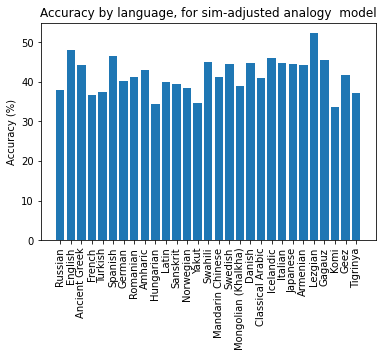

In [116]:
#@title FIG 1.C -- Accuracy by language

heights = [round(100*i, 1) for i in accuracy_list]

x = np.arange(len(common_languages))  # the label locations

fig, ax = plt.subplots()
ax.bar(x, heights)

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by language, for sim-adjusted analogy  model')
ax.set_xticks(x, labels=common_languages, rotation=90)

plt.show()

# stuff

In [191]:
# Summarize accuracies
print("Accuracy")
print("most similar", np.mean(most_similar)/len(test_df))
print("average distance (brute force 1)", np.mean(dist_avg)/len(test_df))
print("analogy (brute force 2)", np.mean(dist_closest)/len(test_df))
print("average distance GMM", np.mean(gmm_avg)/len(test_df))
print("dist to center GMM", np.mean(gmm_center)/len(test_df))
print("dist to center weighted GMM", np.mean(gmm_weighted)/len(test_df))
print("probability of most probable cluster GMM", np.mean(gmm_prob)/len(test_df))
print("\nMRR")
print("most similar", np.mean(most_similar_mrr))
print("average distance (brute force 1)", np.mean(dist_avg_mrr))
print("analogy (brute force 2)", np.mean(dist_closest_mrr))
print("dist to center GMM", np.mean(gmm_center_mrr))
print("dist to center weighted GMM", np.mean(gmm_weighted_mrr))
print("probability of most probable cluster GMM", np.mean(gmm_prob_mrr))

Accuracy
most similar 0.13106960950764007
average distance (brute force 1) 0.0
analogy (brute force 2) 0.38845500848896436
average distance GMM 0.0
dist to center GMM 0.0
dist to center weighted GMM 0.0
probability of most probable cluster GMM 0.0

MRR
most similar 261.72666666666714
average distance (brute force 1) 0.0
analogy (brute force 2) 355.3933333333326
dist to center GMM 0.0
dist to center weighted GMM 0.0
probability of most probable cluster GMM 0.0


## evaluating model performance

In [165]:
# for english data, check how accurate each of the types are

proportion_df = reduce(lambda  left,right: pd.merge(left,right,left_on='type',right_on='type', how='left'), [accuracy_df.groupby('type').sum(), accuracy_df.groupby('type').count()])
proportion_df['ratio'] = proportion_df['accurate_x']/proportion_df['accurate_y']
proportion_df

,accurate_x,meaning1,meaning2,accurate_y,target,word,date,pos,ratio
type,,,,,,,,,
amelioration,1,7,7,7,7,7,7,7,0.142857
analogy,0,1,1,1,1,1,1,1,0.0
antonymy,0,2,2,2,2,2,2,2,0.0
bleaching,0,1,1,1,1,1,1,1,0.0
broadening,4,12,12,12,12,12,12,12,0.333333
"broadening, metaphor",4,6,6,6,6,6,4,6,0.666667
"grammaticalization, permutation",0,1,1,1,1,1,1,1,0.0
grammaticalization; bleaching,0,1,1,1,1,1,1,1,0.0
homophony,1,4,4,4,4,4,4,4,0.25


In [201]:
train_df[train_df['meaning2'].str.contains('day')]

,meaning1,meaning2,realizations,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47,48,49,label
274,Venus,Friday,4,-0.725050,5.666631,3.563590,0.827974,-10.409569,4.697404,-2.509918,...,-1.649564,-1.072729,-3.572804,2.553428,-5.363025,-0.836014,-5.441908,1.832195,-3.508145,5
320,Mercury,Wednesday,3,-0.473696,2.994199,0.794453,1.737051,-12.403816,4.836273,-3.672449,...,-0.693009,0.410315,-4.450518,4.466444,-6.250283,0.461468,-3.915038,4.425570,-2.856463,5
369,sun,Sunday,5,-3.123459,7.385529,1.436155,-1.258425,0.480547,4.641255,-2.193225,...,2.445875,-0.948023,3.021895,3.725285,-4.136689,-3.273757,-6.668966,0.259096,-0.173935,7
579,morning,day,1,0.553269,3.115801,2.954285,1.839544,1.170039,1.991697,1.355490,...,-0.100270,0.295692,0.868543,0.446411,0.784385,2.261492,0.164752,2.237563,0.762048,8
800,Mars,Tuesday,3,0.726766,0.238501,0.699572,-2.248863,-10.468072,7.348207,-1.889935,...,-1.530602,-1.571956,-3.141765,7.081302,-2.753669,-2.148973,-2.814147,1.133237,-2.552402,5
1013,moon,Monday,7,0.665516,1.597268,1.653172,-3.369177,-8.433972,4.701044,-3.508764,...,1.163564,-0.104190,-2.028352,4.878583,-1.103203,0.816633,-2.820643,1.778965,-1.480238,5
1194,middle,Wednesday,1,-3.552578,-0.796497,-5.517027,5.053836,0.888468,6.364206,0.103579,...,-0.471388,-1.568339,-2.665770,1.139729,-4.805422,1.218228,-7.305795,2.802183,-0.348778,2
1305,Jupiter,Thursday,3,0.327321,1.890286,0.890530,0.173392,-12.113697,6.275518,-4.400635,...,-2.304055,-1.116478,-2.645910,5.188831,-4.175137,-1.356846,-4.482701,2.954686,-2.730816,5
1556,sun,day,52,-1.631816,7.103836,2.941786,-0.971925,-1.727403,2.239963,1.398942,...,-0.942370,0.888800,4.448109,-1.335555,-0.033250,-4.000628,-4.220941,2.166261,1.574044,8
1854,market,Sunday,6,-8.361650,-2.520008,4.881807,0.023842,-3.029374,-2.044735,2.600515,...,2.091448,-5.801795,-0.990265,6.500319,-4.177507,-1.247061,-5.692319,-1.794525,-0.552106,6


In [205]:
test_df[test_df['meaning2'].str.contains('day')]

,meaning1,meaning2,realizations,0,1,2,3,4,5,6,...,42,43,44,45,46,47,48,49,accurate,target
131,middle,Wednesday,1,-3.552578,-0.796497,-5.517027,5.053836,0.888468,6.364206,0.103579,...,-1.568339,-2.665770,1.139729,-4.805422,1.218228,-7.305795,2.802183,-0.348778,False,support
422,market,Sunday,6,-8.361650,-2.520008,4.881807,0.023842,-3.029374,-2.044735,2.600515,...,-5.801795,-0.990265,6.500319,-4.177507,-1.247061,-5.692319,-1.794525,-0.552106,True,Sunday
454,Jupiter,Thursday,3,0.327321,1.890286,0.890530,0.173392,-12.113697,6.275518,-4.400635,...,-1.116478,-2.645910,5.188831,-4.175137,-1.356846,-4.482701,2.954686,-2.730816,True,Thursday


In [206]:
# look at potential targets and outcomes 

source = 'Jupiter'
target = 'Thursday'

print(get_potential_targets(source, target))
print(get_potential_targets(source, target)[get_dist_closest(source, get_potential_targets(source, target))[1]])
print(accuracy_df[(accuracy_df['meaning1']==source) & (accuracy_df['meaning2']==target)]['target'])

['Thursday', 'herd', 'spoon', 'latitude', 'window']
Jupiter -> Thursday is similar to ['Venus' 'Friday'] with dist 12.971785000650184
Jupiter -> herd is similar to ['ram' 'battering ram'] with dist 24.18575172877724
Jupiter -> spoon is similar to ['iron' 'iron for pressing clothes'] with dist 22.488861043691074
Jupiter -> latitude is similar to ['lip' 'edge'] with dist 22.74736112985946
Jupiter -> window is similar to ['heel of a foot' 'heel of a shoe'] with dist 25.120723864620018
Thursday
454    Thursday
Name: target, dtype: string


In [194]:
# evaluate concreteness, frequency, valence, and realization differences between accurate and not accurate predictions
# this doesn't work at all for the english data, by the way
# the source_vars_df that i'm loading in is just for the datsemshift data
# it's just a shortcut so i can have the code for that somewhere else
# fun fact, though, throat->ravine is in both datasets verbatim 

import scipy.stats as stats

source_vars_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/all_vars_df.csv')

accuracy_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on=['meaning1', 'meaning2'],right_on=['meaning1', 'meaning2'], how='left'), [accuracy_df, source_vars_df])

accuracy_vars_df['conc_diff'] = accuracy_vars_df['conc_y'] - accuracy_vars_df['conc_x']
accuracy_vars_df['freq_diff'] = accuracy_vars_df['freq_y'] - accuracy_vars_df['freq_x']
accuracy_vars_df['val_diff'] = accuracy_vars_df['val_y'] - accuracy_vars_df['val_x']
accuracy_vars_df['conc_avg'] = (accuracy_vars_df['conc_y'] + accuracy_vars_df['conc_x'])/2
accuracy_vars_df['freq_avg'] = (accuracy_vars_df['freq_y'] + accuracy_vars_df['freq_x'])/2
accuracy_vars_df['val_avg'] = (accuracy_vars_df['val_y'] + accuracy_vars_df['val_x'])/2

accuracy_vars_df['log_freq'] = np.log(accuracy_vars_df['freq_avg'])
accuracy_vars_df['log_real'] = np.log(accuracy_vars_df['realizations'])

for col in [col for col in list(accuracy_vars_df.columns) if col not in ['meaning1', 'meaning2', 'accurate', 'target', 'type', 'word', 'date', 'pos']]:
  print("Average", col, "for accurate:", accuracy_vars_df[accuracy_vars_df['accurate']].mean()[col])
  print("Average", col, "for not accurate:", accuracy_vars_df[~accuracy_vars_df['accurate']].mean()[col])
  print("T-test:", stats.ttest_ind(accuracy_vars_df[col][accuracy_vars_df['accurate'] == True], accuracy_vars_df[col][accuracy_vars_df['accurate'] == False], nan_policy='omit').pvalue)
  print("--")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is 

Average realizations for accurate: 3.7325174825174825
Average realizations for not accurate: 2.9505830094392005
T-test: 0.001653920321651138
--
Average conc_x for accurate: 3.940417041030248
Average conc_x for not accurate: 3.9664029836564043
T-test: 0.4222586507153603
--
Average conc_y for accurate: 3.411235294117647
Average conc_y for not accurate: 3.426635863267671
T-test: 0.7030446659426062
--
Average freq_x for accurate: 36450.356630824375
Average freq_x for not accurate: 30014.537762634867
T-test: 0.05750209391564593
--
Average freq_y for accurate: 40307.54192966637
Average freq_y for not accurate: 38183.37909247559
T-test: 0.6240265281865196
--
Average val_x for accurate: 0.5367444237918216
Average val_x for not accurate: 0.5340828411104549
T-test: 0.7195395944473212
--
Average val_y for accurate: 0.5161092310136638
Average val_y for not accurate: 0.5223913821138212
T-test: 0.49625042230568817
--
Average conc_diff for accurate: -0.5232989611976779
Average conc_diff for not accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is 

In [164]:
# for english dataset -- look at differences in DATE

bad_indices = []
bad_indices += list(accuracy_df[accuracy_df['date']=='OE'].index)
bad_indices += list(accuracy_df[accuracy_df['date']=='eOE'].index)

date_safe_df = accuracy_df.drop(bad_indices)
date_safe_df['date'] = date_safe_df['date'].astype('float64')

print("Average date for accurate:", date_safe_df[date_safe_df['accurate']].mean()['date'])
print("Average date for not accurate:", date_safe_df[~date_safe_df['accurate']].mean()['date'])

print("pvalue for ttest:", stats.ttest_ind(date_safe_df['date'][date_safe_df['accurate'] == True],
                date_safe_df['date'][date_safe_df['accurate'] == False], nan_policy='omit').pvalue)

Average date for accurate: 1530.0833333333333
Average date for not accurate: 1550.514563106796
pvalue for ttest: 0.6237608403046715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by Interac

In [168]:
# for english dataset, check differences in POS

just_pos_df = accuracy_df[['pos', 'accurate']]
accurate_pos_df = reduce(lambda  left,right: pd.merge(left,right,left_on='pos',right_on='pos', how='left'), [just_pos_df[just_pos_df['accurate']].groupby('pos').sum(), just_pos_df.groupby('pos').count()])
accurate_pos_df['percent_accurate'] = accurate_pos_df['accurate_x'] / accurate_pos_df['accurate_y']
accurate_pos_df

,accurate_x,accurate_y,percent_accurate
pos,,,
adj,13,39,0.333333
n,26,125,0.208
v,8,25,0.32


In [131]:
np.log(all_vars_df.sort_values(by='realizations', ascending=False).tail(10)['realizations'])

1603    0.0
1601    0.0
1595    0.0
1593    0.0
368     0.0
1591    0.0
1590    0.0
1589    0.0
370     0.0
0       0.0
Name: realizations, dtype: float64

(array([2.925e+03, 1.400e+01, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  26.8,  52.6,  78.4, 104.2, 130. , 155.8, 181.6, 207.4,
        233.2, 259. ]),
 <a list of 10 Patch objects>)

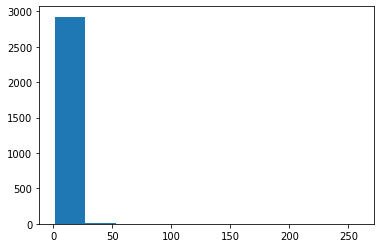

In [143]:
plt.hist(all_vars_df['realizations'])
# plt.plot(range(1, 250, 0.5), [1/i for i in range(1, 250, 0.5)])

(array([1482.,    0.,  515.,  248.,  157.,  282.,  188.,   59.,    8.,
           2.]),
 array([0.        , 0.1880507 , 0.37610139, 0.56415209, 0.75220278,
        0.94025348, 1.12830418, 1.31635487, 1.50440557, 1.69245626,
        1.88050696]),
 <a list of 10 Patch objects>)

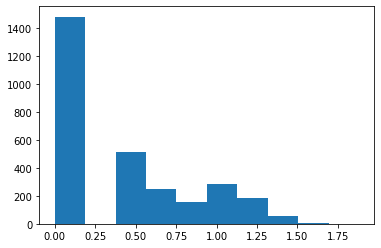

In [136]:
plt.hist(np.log(np.log(all_vars_df['realizations'])+1))

(array([   4.,   57.,  197.,  179.,  260.,  248.,  517.,    0.,    0.,
        1483.]),
 array([0.06213698, 0.15592328, 0.24970958, 0.34349588, 0.43728219,
        0.53106849, 0.62485479, 0.71864109, 0.8124274 , 0.9062137 ,
        1.        ]),
 <a list of 10 Patch objects>)

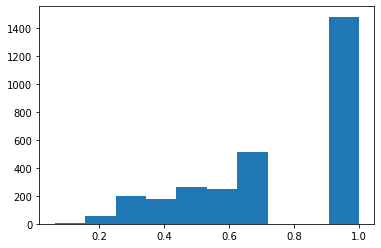

In [124]:
plt.hist(1/np.sqrt(accuracy_df['realizations']))
# plt.hist(date_safe_df['date'])
# plt.hist(accuracy_df['date'][accuracy_df['accurate']==False])

In [82]:
date_safe_df[np.isnan(date_safe_df['date'])]

,meaning1,meaning2,type,accurate,target,word,date,pos,conc_x,conc_y,freq_x,freq_y,val_x,val_y,conc_diff,freq_diff,val_diff,conc_avg,freq_avg,val_avg
21,put away get rid of,to kill,"broadening, metaphor",True,to kill,dispose,NaN,v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,to expel get rid of,to kill,"broadening, metaphor",True,to kill,eliminate,NaN,v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
import scipy.stats as stats

# i will say that this is not normally distributed

stats.ttest_ind(accuracy_df['realizations'][accuracy_df['accurate'] == True],
                accuracy_df['realizations'][accuracy_df['accurate'] == False])



Ttest_indResult(statistic=2.854871946872594, pvalue=0.00433555171581328)

In [108]:
stats.ttest_ind(date_safe_df['date'][date_safe_df['accurate'] == True],
                date_safe_df['date'][date_safe_df['accurate'] == False], nan_policy='omit').pvalue

0.39239916735756375